In [1]:
n = 10000 # narticle
num_hashes = 100 # signature matrix 
k = 10 # shingle

In [2]:
import os
import random     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [3]:
from os import getcwd
TRAIN = os.path.join(getcwd(), 'MinHash/data/articles_'+ str(n) +'.train')
TRUTH = os.path.join(getcwd(), 'MinHash/data/articles_'+ str(n) +'.truth')

In [4]:
def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

def make_hashes(num_hash):
    hash_fns = list() # initialize list for hash functions
    
    for i in range(0, num_hash):
        hash_fns.append(make_random_hash_fn()) # make_random_hash_fn()
        
    return hash_fns

In [5]:
def parse_data(filename):
    if not filename:
        raise ValueError("filename is empty.")
    
    import string
    
    with open(filename) as f:
        content = f.readlines()  # read lines from filename
        content = [x.strip() for x in content]
        exclude = set(string.punctuation)
        tuples = list()
        
    for line in content:
        id, article = line.split(" ", 1)
        article = ''.join(ch for ch in article if ch not in exclude).replace(' ', '').lower()
        tuples.append((id, article))  # construct tuple of id and text
    return tuples 

In [6]:
train = parse_data(TRAIN)

In [7]:
def shingle_document(string, k):
    if not string:
        raise ValueError("String is empty.")
    if not k:
        raise ValueError("k is empty.")
    
    import binascii
    
    unique_hash = set() # initialize set data structure
    for i in range(0, len(string) - k + 1):
        unique_hash.add(binascii.crc32(string[i:i+k].encode("utf-8"))) # hash substring into 32-bit integer
        
    return unique_hash

In [8]:
def shingled_list(document):
    shingled_list = list()
    for d in document:
        shingled_list.append((d[0], shingle_document(d[1], k))) # shingle_document()
    return shingled_list

In [9]:
train_shingled = shingled_list(train)

In [10]:
 def getKey(item):
        return item[0]

In [11]:
def invert_shingles(shingled_documents): # input a list of tuples of form (id, [item])
    if not shingled_documents:
        raise ValueError("filename is empty")
        
    tuples = list() # initialize list for tuples
    ids = list() # initialize list for document ids
    
    for row in shingled_documents:
        ids.append(row[0])
        for item in row[1]:
            tuples.append((item, row[0]))
            
    sorted_tuples = sorted(tuples, key = getKey) # getKey()
    
    return sorted_tuples, ids

In [12]:
def docid_map(docids):
    docid_col_map = dict()
    for i in range(0, len(docids)):
        docid_col_map[docids[i]] = i
    return docid_col_map  

In [13]:
def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids = invert_shingles(shingled_data) # invert_shingles()
    num_docs = len(docids)
    
    docid_col_map = docid_map(docids) # docid_map()
    
    unique_items = {item[0] for item in inv_index}
    sorted_unique_items = sorted(unique_items)
  
    # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)
    
    # generate hash functions
    hash_funcs = make_hashes(num_hashes) # make_hashes()

    for row, docid in inv_index:
        # i = row_map[row] # index of rows
        j = docid_col_map[docid] # index of columes
        for n in range(0, num_hashes):
            sigmatrix[n][j]= min(hash_funcs[n](row), sigmatrix[n][j])
    
    return sigmatrix, docids, docid_col_map

In [14]:
train_sigmatrix, docids, docid_col_map = make_minhash_signature(train_shingled, num_hashes)

In [15]:
# function to generate hash funciton for vectors

def _make_vector_hash(num_hashes, m=4294967295):
    hash_fns = make_hashes(num_hashes)
    def _f(vec):
        acc = 0
        for i in range(len(vec)):
            h = hash_fns[i]
            acc += h(vec[i])
        return acc % m
    return _f

In [16]:
# choose the number of bands to use 

import scipy.optimize as opt
import math

def _choose_nbands(t, n):
    
    def _error_fun(x):
        cur_t = (1/x[0])**(x[0]/n)
        return (t-cur_t)**2
    
    opt_res = opt.minimize(_error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(opt_res['x'][0]))
    r = int(n / b)
    final_t = (1/b)**(1/r)
    return b, final_t

In [17]:
from collections import defaultdict

# locality sensitive hashing
def do_lsh(minhash_sigmatrix, numhashes, docids, threshold):
    
    b, _ = _choose_nbands(threshold, numhashes) # choose_nbands()
    r = int(numhashes / b)
    
    hash_func = _make_vector_hash(r) # _make_vector_hash()

    # initialize a list() of hashtables, will be populated with one hash table per band
    buckets = [] 

    # fill hash tables for each band
    for band in range(b):
       
        # figure out which rows of minhash signature matrix to hash for this band
        start_index = int(band * r)
        end_index = min(start_index + r, numhashes) # keep it in bound
        
        # initialize hashtable for this band
        cur_buckets = defaultdict(list) # defaultdict() list default
        
        for j in range(len(docids)):
            hashes = minhash_sigmatrix[start_index:end_index, j]
            cur_buckets[hash_func(hashes)].append(j)
        
        # add this hashtable to the list of hashtables 
        buckets.append(cur_buckets) # key value pair
        
    return buckets

In [18]:
def find_pairs(buckets):
    
    pair_list = list()
    pair_tuple = list()
    for row in buckets:
        all = [x for x in row.values() if len(x) > 1]
        
        for ind in all:
            pair_tuple.extend(list(itertools.combinations(tuple(ind), 2)))
            
        return set(pair_tuple)

In [19]:
truth = parse_data(TRUTH)
truth_map = list()
for row in truth:
    i = docid_col_map[row[0]]
    j = docid_col_map[row[1]]
    truth_map.append((i, j))

In [25]:
def test_threshold(threshold):
    tuples = list()
    r = 2
    
    for t in np.arange(0.1, threshold, 0.05):
        
        buckets = do_lsh(train_sigmatrix, len(train_sigmatrix), docids, t)
        predicted = list(find_pairs(buckets))
        
        print("threshold = " + str(t))
        print("Len of Predicted: " + str(len(predicted)))
        print("Len of Truth: " + str(len(truth_map)))
        
        TP = len([x for x in truth_map if x in predicted])
        print("TP = " + str(TP))
        
        FP = len(predicted) - TP
        print("FP = " + str(FP))
        
        ALL = math.factorial(n)/(math.factorial(n-r)*math.factorial(r))
        
        TN =  ALL - len(predicted) - len(truth_map) + TP
        print("TN = " + str(TN))
        
        FN = len(truth_map) - TP
        print("FN = " + str(FN))
        
        sensitivity = TP/(TP + FN) # TP/(TP + FN)
        specificity = TN/(TN + FP) # TN/(TN + FP)
        
        tuples.append((t, sensitivity, specificity))
        
    return tuples

In [26]:
data = test_threshold(1)

threshold = 0.1
Len of Predicted: 283383
Len of Truth: 80
TP = 39
FP = 283344
TN = 49711576.0
FN = 41
threshold = 0.15000000000000002
Len of Predicted: 2442
Len of Truth: 80
TP = 39
FP = 2403
TN = 49992517.0
FN = 41
threshold = 0.20000000000000004
Len of Predicted: 2442
Len of Truth: 80
TP = 39
FP = 2403
TN = 49992517.0
FN = 41
threshold = 0.25000000000000006
Len of Predicted: 2442
Len of Truth: 80
TP = 39
FP = 2403
TN = 49992517.0
FN = 41
threshold = 0.30000000000000004
Len of Predicted: 2442
Len of Truth: 80
TP = 39
FP = 2403
TN = 49992517.0
FN = 41
threshold = 0.3500000000000001
Len of Predicted: 105
Len of Truth: 80
TP = 38
FP = 67
TN = 49994853.0
FN = 42
threshold = 0.40000000000000013
Len of Predicted: 105
Len of Truth: 80
TP = 38
FP = 67
TN = 49994853.0
FN = 42
threshold = 0.45000000000000007
Len of Predicted: 77
Len of Truth: 80
TP = 38
FP = 39
TN = 49994881.0
FN = 42
threshold = 0.5000000000000001
Len of Predicted: 77
Len of Truth: 80
TP = 38
FP = 39
TN = 49994881.0
FN = 42
th

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


threshold = 0.9500000000000003
Len of Predicted: 67
Len of Truth: 80
TP = 32
FP = 35
TN = 49994885.0
FN = 48


In [27]:
dt = pd.DataFrame(data, columns = ["threshold", "sensitivity", "specificity"])

In [28]:
dt

,threshold,sensitivity,specificity
0,0.10,0.4875,0.994333
1,0.15,0.4875,0.999952
2,0.20,0.4875,0.999952
3,0.25,0.4875,0.999952
4,0.30,0.4875,0.999952
5,0.35,0.4750,0.999999
6,0.40,0.4750,0.999999
7,0.45,0.4750,0.999999
8,0.50,0.4750,0.999999
9,0.55,0.4750,0.999999


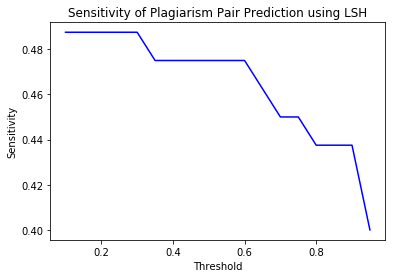

In [34]:
plt.plot(dt.threshold, dt.sensitivity, color = "blue")
plt.title("Sensitivity of Plagiarism Pair Prediction using LSH")
plt.xlabel("Threshold")
plt.ylabel("Sensitivity")
plt.show()

### My thougts:
#### Sensitivity is also called true positive rate, defined as TP/(TP+FN).
#### Low sensitivity means that in positive test, accuracy of negative prediction is low. If prediction says that this is plagiarism, it is likely to be non-plagiarism.
#### We can see from the experiement that as threshold increases, sensitivity decreases, which means that the accuracy of predicing plagiarism in a positive test is low and decreases as threshold increases.

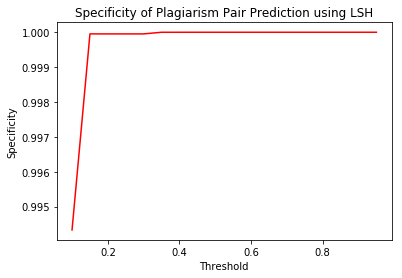

In [36]:
plt.plot(dt.threshold, dt.specificity, color = "Red")
plt.title("Specificity of Plagiarism Pair Prediction using LSH")
plt.xlabel("Threshold")
plt.ylabel("Specificity")
plt.show()

### My thoughts:
#### Specificy is also called true negative rate, defined as TN/(TN+FP).
#### High specificity means that in negative test, accuracy of positive prediction is very high. If prediction says that it is non-plagiarism, it is very likely to be non-plagiarism.
#### We can see from the experiement that as threshold increases, specificity increases sharply, which means that accuracy of predicting non-plagiarism in a negative test is very high and increases as threshold increases.